In [2]:
using Pkg
Pkg.activate("..")
Pkg.resolve() 
Pkg.instantiate()
using DifferentialEquations,JPEC, Plots, DelimitedFiles

  Activating project at `~/Desktop/JPEC`
  No Changes to `~/Desktop/JPEC/Project.toml`
  No Changes to `~/Desktop/JPEC/Manifest.toml`


In [4]:
equil_input = JPEC.Equilibrium.EquilConfig(; control=JPEC.Equilibrium.EquilControl(eq_type="lar", eq_filename="lar.toml"), output=JPEC.Equilibrium.EquilOutput())
lar_input = JPEC.Equilibrium.LargeAspectRatioConfig(; lar_r0=10, lar_a=1, beta0=0.001, q0=1.5, p_pres=2, p_sig=1)

┌ Info: Forcing hamada coordinate jacobian exponents: power_*
└ @ JPEC.Equilibrium /Users/iseonjae/Desktop/JPEC/src/Equilibrium/EquilibriumTypes.jl:48


JPEC.Equilibrium.LargeAspectRatioConfig(10.0, 1.0, 0.001, 1.5, 2.0, 1.0, "default", 128, 128, false)

In [5]:
plasma_eq= JPEC.Equilibrium.setup_equilibrium(equil_input, lar_input)

Equilibrium file: lar.toml
--- Starting Inverse Equilibrium Processing ---
--- Equilibrium Setup Complete ---


JPEC.Equilibrium.PlasmaEquilibrium(JPEC.Equilibrium.EquilConfig(JPEC.Equilibrium.EquilControl("lar", "lar.toml", "hamada", 0, 0, 0, "ldp", 0.01, 0.994, 128, 256, 0, 1.0e-7, false, false, true), JPEC.Equilibrium.EquilOutput(false, false, false, false, true, false, false, false)), JPEC.SplinesMod.RealSplineType(Ptr{Nothing} @0x000000033e4272d0, [0.01, 0.010148181201467524, 0.010592635547055184, 0.011333095314084414, 0.012369114477279132, 0.013700068977434681, 0.015325157097327761, 0.017243399944640907, 0.019453642041610618, 0.021954552021043953  …  0.9820454479789561, 0.9845463579583893, 0.986756600055359, 0.9886748429026722, 0.9902999310225652, 0.9916308855227208, 0.9926669046859157, 0.9934073644529449, 0.9938518187985325, 0.994], [62.830366651502736 0.0004930704809030368 137.73479506687505 1.5104475665001562; 62.83034482525349 0.0004929677989738323 137.74890591352013 1.5106034131306179; … ; 62.75886344741364 3.618352407563644e-8 -22999.473626511397 -253.74075808458534; 62.7588563259654

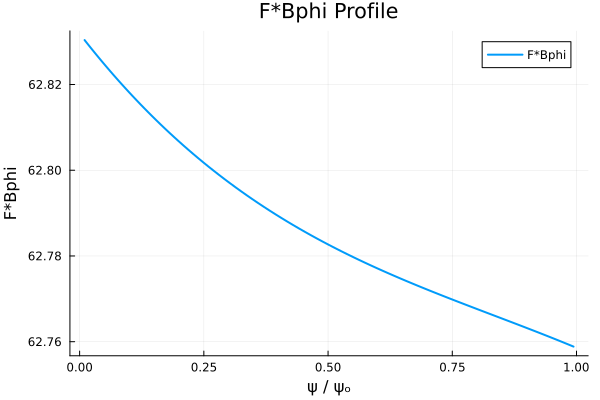

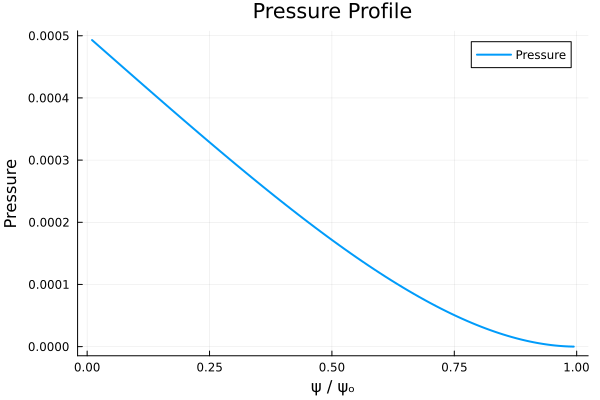

In [ ]:
function save_and_plot_sq_in(sq_in, filename_prefix="sq_in")
    xs = sq_in._xs
    fs = sq_in._fs  # size = (ma+1, 3): [F*Bphi, pressure, q]

    # Save all data to a single txt file
    data = hcat(xs, fs)

    # Plot 1: F*Bphi
    p1 = plot(xs, fs[:,1], label="F*Bphi", xlabel="ψ / ψₒ", ylabel="F*Bphi", lw=2, title="F*Bphi Profile")
    display(p1)

    # Plot 2: Pressure
    p2 = plot(xs, fs[:,2], label="Pressure", xlabel="ψ / ψₒ", ylabel="Pressure", lw=2, title="Pressure Profile")
    display(p2)

end

save_and_plot_sq_in(plasma_eq.sq, "sq_in")